In [1]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import threading
import matplotlib.pyplot as plt

Define a Simple neural network

In [4]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Centarlized Learning Client

In [5]:
class FederatedClient(threading.Thread):
    def __init__(self, model, optimizer, train_loader):
        super(FederatedClient, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.training_losses = []  # to store training losses

    def run(self):
        self.train()

    def train(self):
        self.model.train()
        for epoch in range(3):  # Number of local epochs
            for batch_idx, (data, target) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                self.optimizer.step()
                if batch_idx % 100 == 0:
                    print('Client Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(self.train_loader.dataset),
                        100. * batch_idx / len(self.train_loader), loss.item()))
                    self.training_losses.append(loss.item())


Federated Learning setup

In [6]:
def federated_learning():
    # Define the global model
    global_model = SimpleNet()

    # Define optimizer and criterion
    optimizer = optim.SGD(global_model.parameters(), lr=0.01, momentum=0.9)

    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

    # Create and start federated clients
    num_clients = 5
    clients = [FederatedClient(SimpleNet(), optimizer, train_loader) for _ in range(num_clients)]
    for client in clients:
        client.start()

    # Wait for all clients to finish training
    for client in clients:
        client.join()

    # Aggregate model parameters from all clients
    for client in clients:
        global_model.fc1.weight.data += client.model.fc1.weight.data / num_clients
        global_model.fc1.bias.data += client.model.fc1.bias.data / num_clients
        global_model.fc2.weight.data += client.model.fc2.weight.data / num_clients
        global_model.fc2.bias.data += client.model.fc2.bias.data / num_clients

    # Optionally, save or use the global model for further testing or training
    # Evaluate the global model on a test dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Plot the training losses
    for i, client in enumerate(clients):
        plt.plot(range(len(client.training_losses)), client.training_losses, label=f'Client {i+1}')

    plt.xlabel('Batch Index')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()



Run Federated Learning

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:13<00:00, 729999.22it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 114134.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 928590.51it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3446188.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Client Training Epoch: 0 [0/60000 (0%)]	Loss: 2.318001Client Training Epoch: 0 [0/60000 (0%)]	Loss: 2.312298

Client Training Epoch: 0 [0/60000 (0%)]	Loss: 2.312269
Client Training Epoch: 0 [0/60000 (0%)]	Loss: 2.379744
Client Training Epoch: 0 [0/60000 (0%)]	Loss: 2.292980
Client Training Epoch: 0 [6400/60000 (11%)]	Loss: 2.327645
Client Training Epoch: 0 [6400/60000 (11%)]	Loss: 2.343379
Client Training Epoch: 0 [6400/60000 (11%)]	Loss: 2.350905
Client Training Epoch: 0 [6400/60000 (11%)]	Loss: 2.283571
Client Training Epoch: 0 [6400/60000 (11%)]	Loss: 2.390203
Client Training Epoch: 0 [12800/60000 (21%)]	Loss: 2.397952
Client Training Epoch: 0 [12800/60000 (21%)]	Loss: 2.329132
Client Training Epoch: 0 [12800/60000 (21%)]	Loss: 2.276448
Client Training Epoch: 0 [12800/60000 (21%)]	Loss: 2.325780
Client Training Epoch: 0 [12800/60000 (21%)]	Loss: 2.319734
Client Training Epoch: 0 [19200/60000 (32%)]	Loss: 2.329537
Client Training Epoch: 0 [19200/60000 (32%)]	Loss: 2.343431
Client Tra

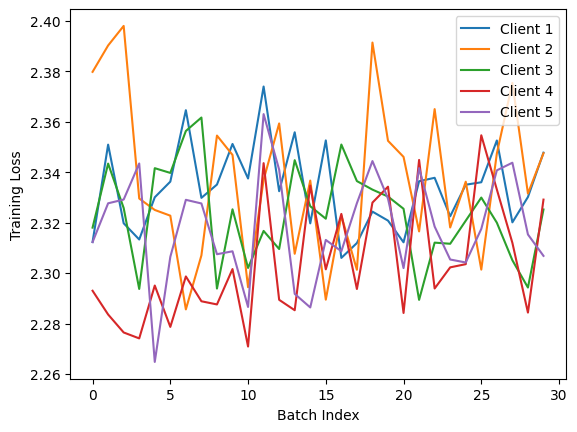

In [7]:
federated_learning()